Fetching dataset from Kaggle... Please wait.
Using Colab cache for faster access to the 'flight-delays' dataset.
Preprocessing complete.


<Figure size 1600x1400 with 0 Axes>

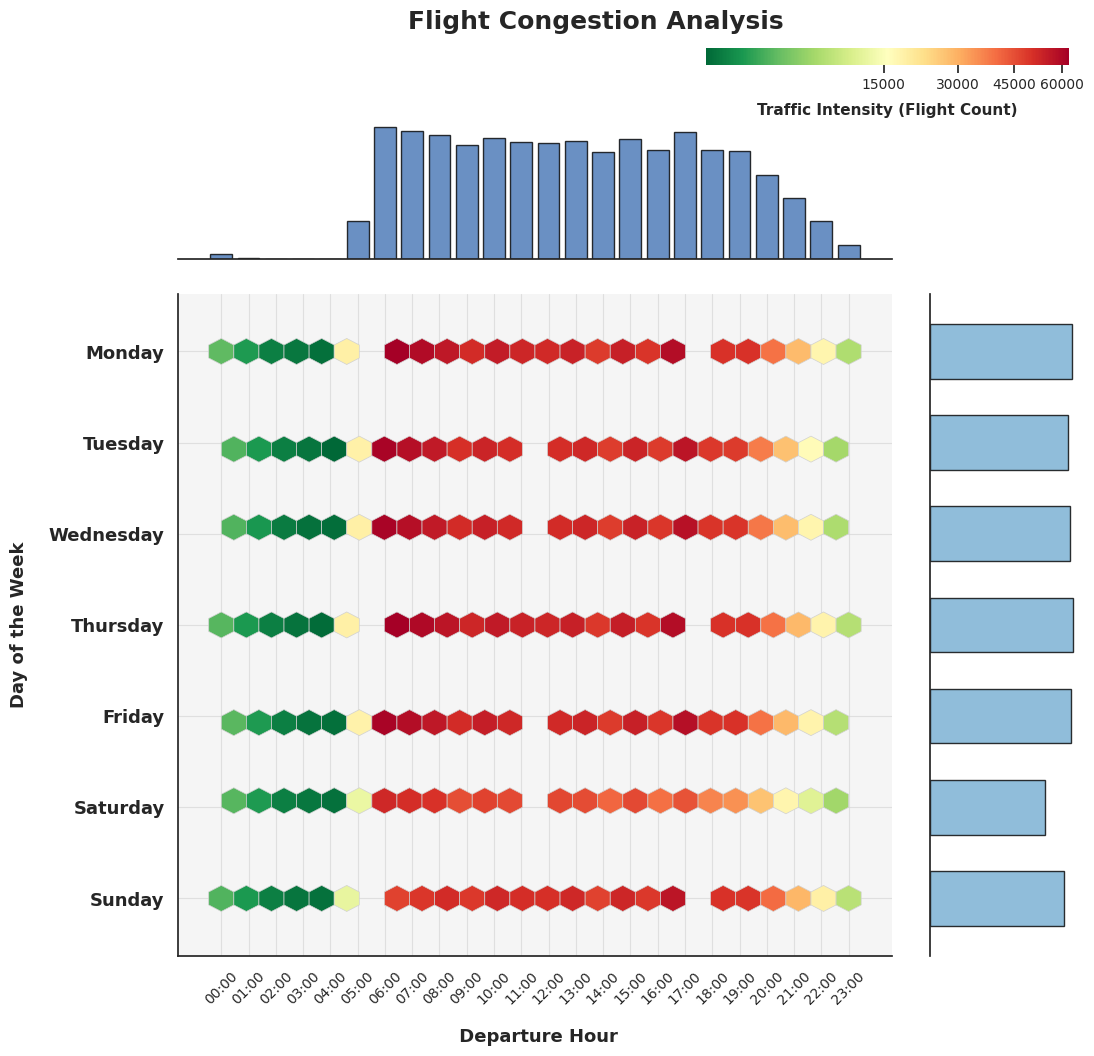

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import PowerNorm
import matplotlib.ticker as ticker
import kagglehub
import os
import glob

# --- 1. DATA ACQUISITION & ERROR HANDLING ---
try:
    # Check for local file first for offline compatibility (Instructor-friendly)
    local_path = os.path.join('data', 'flights.csv')
    if os.path.exists(local_path):
        print("Loading data from local repository...")
        df_rq2 = pd.read_csv(local_path, low_memory=False)
    else:
        print("Fetching dataset from Kaggle... Please wait.")
        path = kagglehub.dataset_download("usdot/flight-delays")
        csv_path = glob.glob(os.path.join(path, "**/flights.csv"), recursive=True)[0]
        df_rq2 = pd.read_csv(csv_path, low_memory=False)

    # Feature Engineering: Extracting temporal components
    # Extracting hour from HHMM format
    df_rq2['HOUR'] = (df_rq2['SCHEDULED_DEPARTURE'] // 100 % 24).astype(int)
    df_rq2['DATE'] = pd.to_datetime(df_rq2[['YEAR', 'MONTH', 'DAY']])
    df_rq2['DAY_NAME'] = df_rq2['DATE'].dt.day_name()

    # Academic Sorting: Mapping days to ensure Monday is at the top
    day_map_en = {'Monday': 7, 'Tuesday': 6, 'Wednesday': 5, 'Thursday': 4,
                  'Friday': 3, 'Saturday': 2, 'Sunday': 1}
    df_rq2['DAY_NUM_EN'] = df_rq2['DAY_NAME'].map(day_map_en)

    print("Preprocessing complete.")
except Exception as e:
    print(f"Operational Error: {e}")

# --- 2. CANVAS CONFIGURATION ---
sns.set_theme(style="white")
fig = plt.figure(figsize=(16, 14))

# JointGrid Structure: Defining main plot and marginal distribution axes
g = sns.JointGrid(data=df_rq2, x='HOUR', y='DAY_NUM_EN', height=11, ratio=4, space=0.25)

# --- 3. CENTRAL HEATMAP (HEXBIN) ---
g.ax_joint.set_facecolor('#f5f5f5')

# Hexbin Plotting: Green (Low) -> Yellow -> Red (High Congestion)
hb = g.plot_joint(
    plt.hexbin, cmap='RdYlGn_r', gridsize=25, norm=PowerNorm(gamma=0.5),
    mincnt=1, edgecolors='#d1d1d1', linewidths=0.5
)

# --- 4. MARGINAL DISTRIBUTIONS ---
# Top Bar: Hourly Volume
hour_counts = df_rq2['HOUR'].value_counts().sort_index()
g.ax_marg_x.bar(hour_counts.index, hour_counts.values, color='#4575b4', alpha=0.8, edgecolor='black')

# Right Bar: Daily Volume
day_counts = df_rq2['DAY_NUM_EN'].value_counts().sort_index()
g.ax_marg_y.barh(day_counts.index, day_counts.values, color='#74add1', alpha=0.8, edgecolor='black', height=0.6)

# --- 5. COLORBAR CONFIGURATION (CLEAN SCALE) ---
mappable = g.ax_joint.collections[0]
cax = g.fig.add_axes([0.60, 0.93, 0.33, 0.015])
cb = plt.colorbar(mappable, cax=cax, orientation='horizontal')

# FIXED TICKS: Removing the starting '0' to match the requested clean look
# Ticks start only from 15000 as per user requirement
ticks = [15000, 30000, 45000, 60000]
cb.set_ticks(ticks)
cb.ax.set_xticklabels(['15000', '30000', '45000', '60000'])

cb.ax.tick_params(labelsize=10)
cb.set_label('Traffic Intensity (Flight Count)', fontsize=11, fontweight='bold', labelpad=8)
cb.outline.set_visible(False)

# --- 6. AXES & GRID CALIBRATION ---
en_days = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']
g.ax_joint.set_yticks(range(1, 8))
g.ax_joint.set_yticklabels(en_days, fontsize=13, fontweight='bold')

g.ax_joint.set_xticks(range(0, 24))
g.ax_joint.set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=45, fontsize=10)

# High-Visibility Grid
g.ax_joint.grid(True, which='major', axis='both', linestyle='-', color='#d1d1d1', alpha=0.6, linewidth=0.8)

g.ax_joint.set_xlabel(' Departure Hour', fontsize=13, fontweight='bold', labelpad=15)
g.ax_joint.set_ylabel('Day of the Week', fontsize=13, fontweight='bold', labelpad=15)

# --- 7. FINAL LAYOUT ---
plt.subplots_adjust(top=0.88, right=0.94, left=0.12, bottom=0.12)
plt.suptitle('Flight Congestion Analysis', y=0.98, fontsize=18, fontweight='bold')

plt.show()